<a href="https://colab.research.google.com/github/ChristophWuersch/AppliedNeuralNetworks/blob/main/U02/BinaryClassification_HeartDataset_SOLUTION-PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="Bilder/ost_logo.png" width="240" height="120" align="right"/>
<div style="text-align: left"> <b> Applied Neural Networks | FS 2025 </b><br>
<a href="mailto:christoph.wuersch@ost.ch"> © Christoph Würsch </a> </div>
<a href="https://www.ost.ch/de/forschung-und-dienstleistungen/technik/systemtechnik/ice-institut-fuer-computational-engineering/"> Eastern Switzerland University of Applied Sciences OST | ICE </a>

# Binäre Klassifikation mit kontinuierlichen und kategorischen Merkmalen

**Author:** 
- Christoph Würsch, Eastern Switzerland University of Applied Science OST
- [Francois Chollet](https://twitter.com/fchollet)<br>



Diese Übungsserie zeigt, wie eine strukturierte Datenklassifizierung ausgehend von einer rohen
CSV-Datei mit keras vorgenommen werden kann. Die verwendeten Daten enthalten sowohl numerische als auch kategorische Merkmale. Wir verwenden Keras Vorverarbeitungsschichten zur Normalisierung der numerischen Merkmale und zur Vektorisierung (one-hot-coding) der kategorischen Merkmale.

### Der Datensatz

[Unser Datensatz](https://archive.ics.uci.edu/ml/datasets/heart+Disease) wird von der Cleveland Clinic Foundation für Herzkrankheiten zur Verfügung gestellt. Es handelt sich um eine CSV-Datei mit 303 Zeilen. Jede Zeile enthält Informationen über einen Patienten (eine **Stichprobe**), und jede Spalte beschreibt ein Attribut des Patienten (ein **Merkmal**). Wir verwenden die Merkmale, um vorherzusagen, ob ein Patient eine Herzerkrankung hat (**binäre Klassifizierung**).



Hier ist eine Zusammenfassung der Merkmale:

Column| Description| Feature Type
------------|--------------------|----------------------
Age | Age in years | Numerical
Sex | (1 = male; 0 = female) | Categorical
CP | Chest pain type (0, 1, 2, 3, 4) | Categorical
Trestbpd | Resting blood pressure (in mm Hg on admission) | Numerical
Chol | Serum cholesterol in mg/dl | Numerical
FBS | fasting blood sugar in 120 mg/dl (1 = true; 0 = false) | Categorical
RestECG | Resting electrocardiogram results (0, 1, 2) | Categorical
Thalach | Maximum heart rate achieved | Numerical
Exang | Exercise induced angina (1 = yes; 0 = no) | Categorical
Oldpeak | ST depression induced by exercise relative to rest | Numerical
Slope | Slope of the peak exercise ST segment | Numerical
CA | Number of major vessels (0-3) colored by fluoroscopy | Both numerical & categorical
Thal | 3 = normal; 6 = fixed defect; 7 = reversible defect | Categorical
Target | Diagnosis of heart disease (1 = true; 0 = false) | Target

## Setup

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pandas as pd
import sys

# Print versions in a compact form
print(f"Python version: {sys.version}")
print(f"torch: {torch.__version__}")
print(f"matplotlib: {matplotlib.__version__}")
print(f"numpy: {np.__version__}")
print(f"pandas: {pd.__version__}")

Python version: 3.9.19 (main, May  6 2024, 20:12:36) [MSC v.1916 64 bit (AMD64)]
torch: 2.5.1+cpu
matplotlib: 3.9.2
numpy: 1.23.5
pandas: 2.0.3


## (a) Datensatz laden

Wir laden wir die Daten herunter und speichern diese in einen Pandas-Dataframe:

In [2]:

file_url = "http://storage.googleapis.com/download.tensorflow.org/data/heart.csv"
df = pd.read_csv(file_url)


In [3]:
df.to_csv('heart.csv')

Der Datensatz umfasst 303 Proben mit 14 Spalten pro Probe (13 Merkmale, plus die Zielbezeichnung Bezeichnung):

In [4]:
df.shape

(303, 14)

Die letzte Spalte, `target`, gibt an, ob der Patient eine Herzerkrankung hat (`1`) oder nicht (`0`).


## (b) EDA

Hier ist ein kurzer Einblick in die Daten:

In [5]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0,fixed,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,normal,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2,reversible,0
3,37,1,3,130,250,0,0,187,0,3.5,3,0,normal,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,normal,0


In [6]:
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.594059,0.676568,3.108911,131.785479,246.547855,0.148515,0.990099,149.194719,0.326733,1.057756,1.590759,0.683168,0.273927
std,9.016370,0.468560,1.028414,17.748338,52.175933,0.356198,0.988293,23.173368,0.469794,1.165025,0.617767,0.937773,0.446710
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,48.000000,0.000000,2.000000,120.000000,211.000000,0.000000,0.000000,132.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,56.000000,1.000000,3.000000,130.000000,241.000000,0.000000,1.000000,152.000000,0.000000,0.800000,2.000000,0.000000,0.000000
75%,61.000000,1.000000,4.000000,140.000000,275.000000,0.000000,2.000000,165.500000,1.000000,1.600000,2.000000,1.000000,1.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000,1.000000


In [7]:
# Select only numeric columns
numeric_features= df.select_dtypes(include=['number']).columns.tolist()
print(numeric_features)

corr=df[numeric_features].corr()    



['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'target']


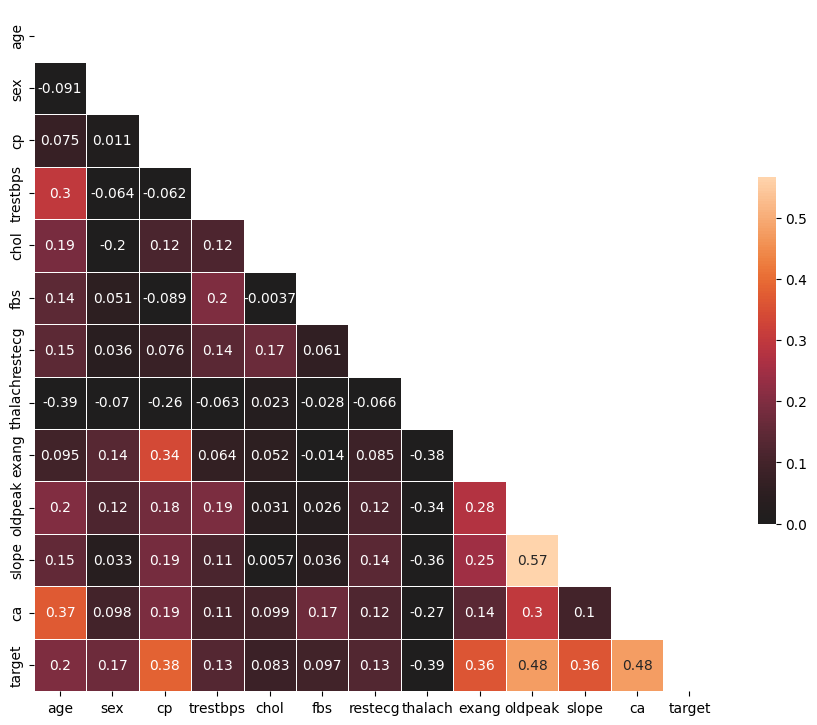

In [8]:
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool_)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, vmin=0.0, center=0, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});
plt.show()

In [9]:
features=df.columns[0:-1]
response=df.columns[-1]

features

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal'],
      dtype='object')

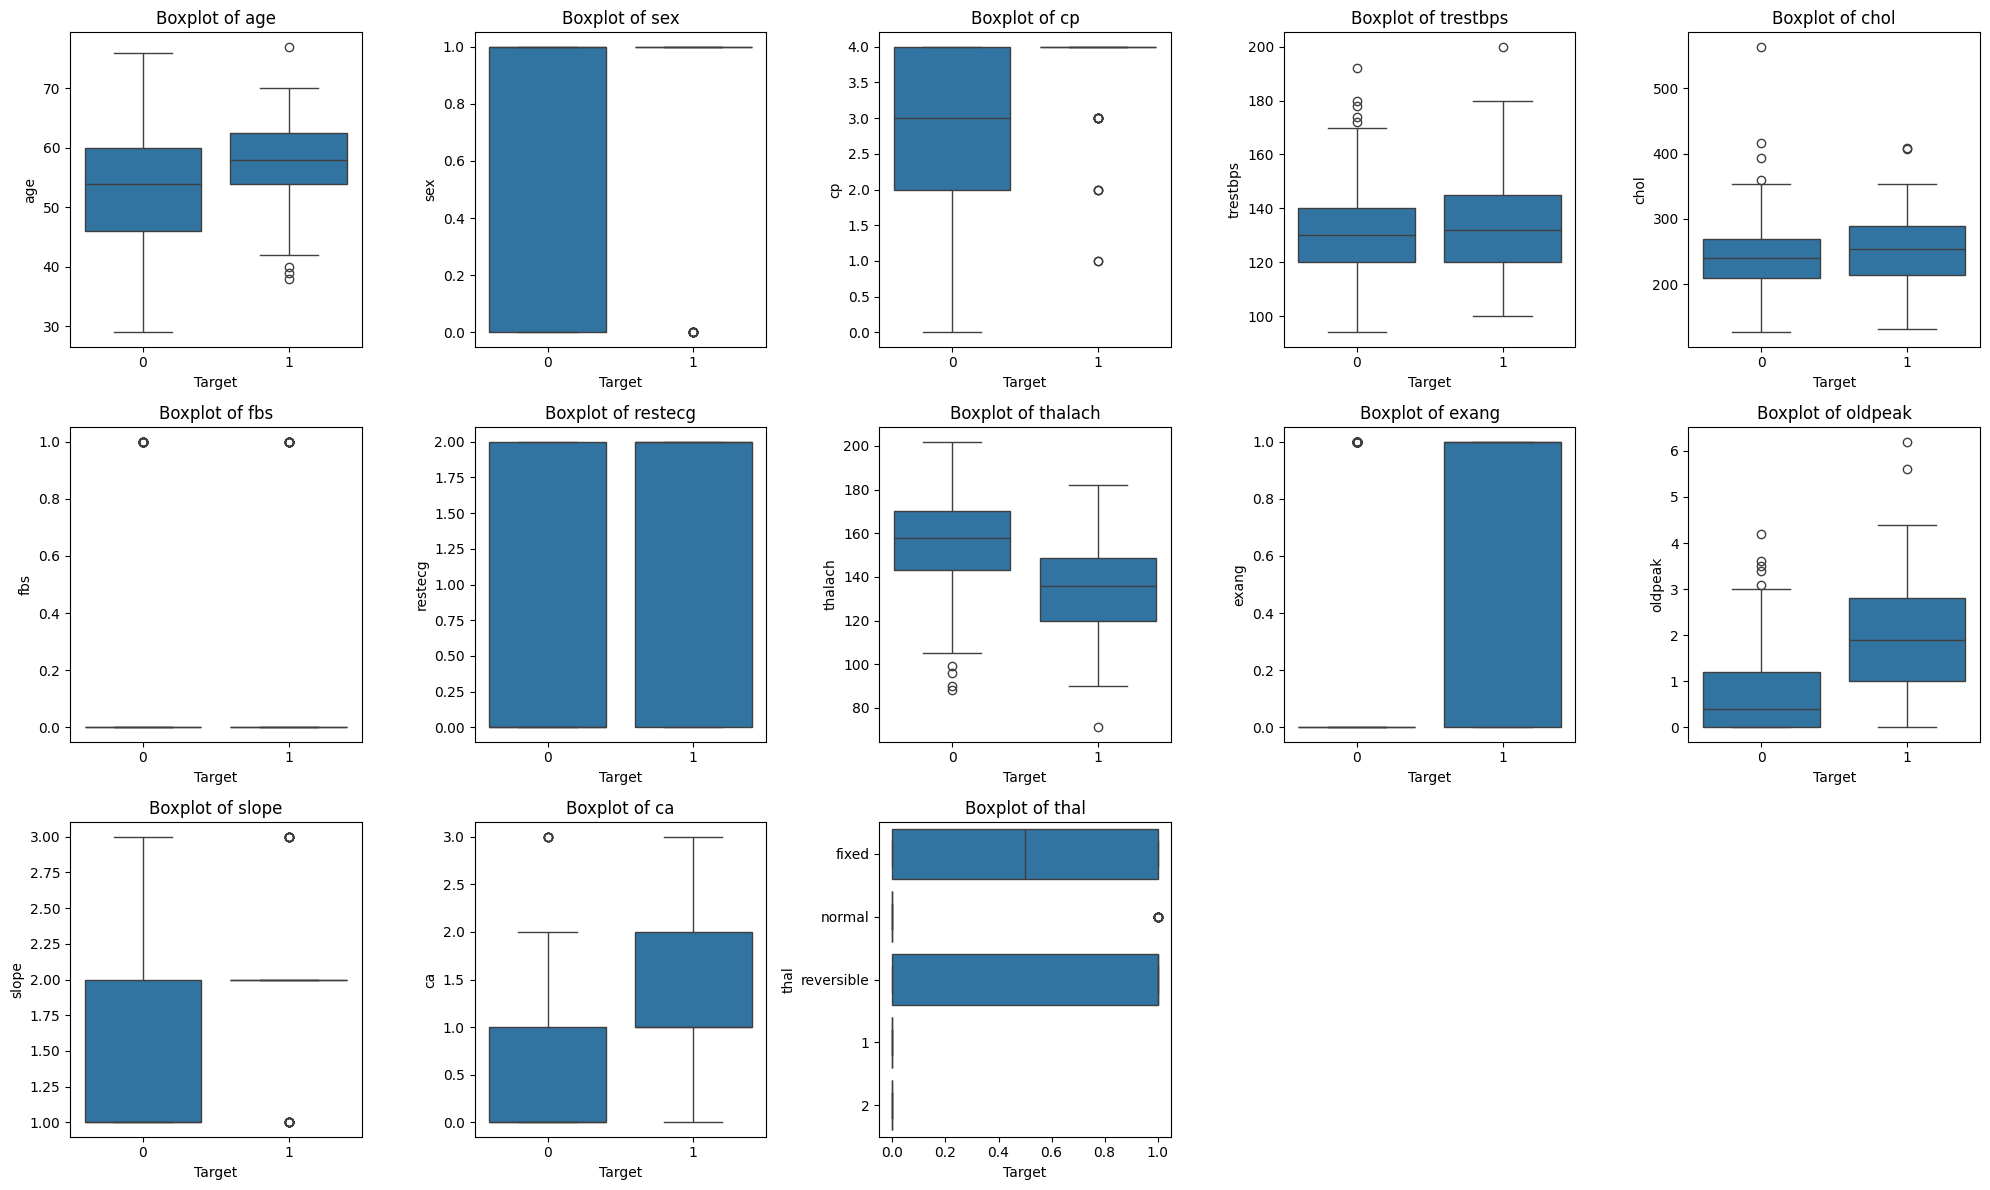

In [10]:
# Create a 3x5 grid of subplots
fig, axes = plt.subplots(3, 5, figsize=(20, 12))  # Adjust figsize for readability

# Flatten axes for easy iteration
axes = axes.flatten()

# Loop through features and create boxplots
for i, feature in enumerate(features):
    sns.boxplot(data=df, x='target', y=feature, ax=axes[i])
    axes[i].set_title(f'Boxplot of {feature}')
    axes[i].set_xlabel('Target')
    axes[i].set_ylabel(feature)

# Hide any unused subplots (if features < 15)
for i in range(len(features), len(axes)):
    fig.delaxes(axes[i])

# Adjust layout
plt.tight_layout()
plt.show()


## (c) Standardisierung und One-hot-Encoding

Die folgenden Merkmale sind kategorische Merkmale, die als ganze Zahlen kodiert sind:

- `Geschlecht`
- `cp` 
- `fbs`
- `restecg`
- `exang`
- `ca`

Wir kodieren diese Merkmale mit **one-hot encoding**. Wir haben zwei Optionen

In [11]:
print(df.dtypes)

age           int64
sex           int64
cp            int64
trestbps      int64
chol          int64
fbs           int64
restecg       int64
thalach       int64
exang         int64
oldpeak     float64
slope         int64
ca            int64
thal         object
target        int64
dtype: object


In [12]:
categorical= ['sex', 'cp', 'fbs', 'restecg', 'exang', 'ca', 'thal']

df_onehot=pd.get_dummies(data=df.iloc[:,1:-1],columns=categorical)

features=df_onehot.columns
features


Index(['trestbps', 'chol', 'thalach', 'oldpeak', 'slope', 'sex_0', 'sex_1',
       'cp_0', 'cp_1', 'cp_2', 'cp_3', 'cp_4', 'fbs_0', 'fbs_1', 'restecg_0',
       'restecg_1', 'restecg_2', 'exang_0', 'exang_1', 'ca_0', 'ca_1', 'ca_2',
       'ca_3', 'thal_1', 'thal_2', 'thal_fixed', 'thal_normal',
       'thal_reversible'],
      dtype='object')

In [13]:
df_onehot.head()

,trestbps,chol,thalach,oldpeak,slope,sex_0,sex_1,cp_0,cp_1,cp_2,...,exang_1,ca_0,ca_1,ca_2,ca_3,thal_1,thal_2,thal_fixed,thal_normal,thal_reversible
0,145,233,150,2.3,3,False,True,False,True,False,...,False,True,False,False,False,False,False,True,False,False
1,160,286,108,1.5,2,False,True,False,False,False,...,True,False,False,False,True,False,False,False,True,False
2,120,229,129,2.6,2,False,True,False,False,False,...,True,False,False,True,False,False,False,False,False,True
3,130,250,187,3.5,3,False,True,False,False,False,...,False,True,False,False,False,False,False,False,True,False
4,130,204,172,1.4,1,True,False,False,False,True,...,False,True,False,False,False,False,False,False,True,False


## (d) Aufteilen in einen Trainings- und Validierungsdatensatz

Wir teilen den Datensatz auf in einen Trainings- und Validierungsdatensatz. Hierfür verwenden wir direkt die Methoden `df.sample` und `df.drop()` eines Pandas-Datenframes `df`. 

In [14]:
#Generate Dataframe with correct encodiding
numericFeatures=features[0:5]
categoricFeatures=features[5:]

print(numericFeatures)
print(categoricFeatures)

Index(['trestbps', 'chol', 'thalach', 'oldpeak', 'slope'], dtype='object')
Index(['sex_0', 'sex_1', 'cp_0', 'cp_1', 'cp_2', 'cp_3', 'cp_4', 'fbs_0',
       'fbs_1', 'restecg_0', 'restecg_1', 'restecg_2', 'exang_0', 'exang_1',
       'ca_0', 'ca_1', 'ca_2', 'ca_3', 'thal_1', 'thal_2', 'thal_fixed',
       'thal_normal', 'thal_reversible'],
      dtype='object')


In [15]:
df_onehot[features].dtypes

trestbps             int64
chol                 int64
thalach              int64
oldpeak            float64
slope                int64
sex_0                 bool
sex_1                 bool
cp_0                  bool
cp_1                  bool
cp_2                  bool
cp_3                  bool
cp_4                  bool
fbs_0                 bool
fbs_1                 bool
restecg_0             bool
restecg_1             bool
restecg_2             bool
exang_0               bool
exang_1               bool
ca_0                  bool
ca_1                  bool
ca_2                  bool
ca_3                  bool
thal_1                bool
thal_2                bool
thal_fixed            bool
thal_normal           bool
thal_reversible       bool
dtype: object

In [16]:
X=df_onehot[features].astype(np.float32).to_numpy()
y=df['target'].to_numpy()

In [17]:
import numpy as np
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [18]:
X_train

array([[150., 276., 112., ...,   1.,   0.,   0.],
       [110., 229., 168., ...,   0.,   0.,   1.],
       [130., 315., 162., ...,   0.,   1.,   0.],
       ...,
       [125., 300., 171., ...,   0.,   0.,   1.],
       [125., 273., 152., ...,   0.,   1.,   0.],
       [160., 289., 145., ...,   0.,   0.,   1.]], dtype=float32)

In [19]:
dg=pd.DataFrame(data=X_train, columns=features)
dg.head()

,trestbps,chol,thalach,oldpeak,slope,sex_0,sex_1,cp_0,cp_1,cp_2,...,exang_1,ca_0,ca_1,ca_2,ca_3,thal_1,thal_2,thal_fixed,thal_normal,thal_reversible
0,150.0,276.0,112.0,0.6,2.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,110.0,229.0,168.0,1.0,3.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,130.0,315.0,162.0,1.9,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,108.0,309.0,156.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,142.0,177.0,160.0,1.4,3.0,1.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## (e) Standardisieren der quantitativen, kontinuierlichen Merkmale

In [20]:
from sklearn.preprocessing import StandardScaler

myScaler=StandardScaler()
Xtrain= np.hstack((myScaler.fit_transform(X_train[:,0:5]),X_train[:,5:]))
Xtest = np.hstack((myScaler.fit_transform(X_test[:,0:5]),X_test[:,5:]))


In [21]:
np.shape(Xtrain)

(203, 28)

In [22]:
Xtrain

array([[ 0.9897748 ,  0.5339174 , -1.5776277 , ...,  1.        ,
         0.        ,  0.        ],
       [-1.234069  , -0.4035331 ,  0.7943432 , ...,  0.        ,
         0.        ,  1.        ],
       [-0.12214708,  1.3118019 ,  0.54020345, ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [-0.40012756,  1.0126156 ,  0.92141306, ...,  0.        ,
         0.        ,  1.        ],
       [-0.40012756,  0.47408015,  0.11663721, ...,  0.        ,
         1.        ,  0.        ],
       [ 1.5457357 ,  0.7932123 , -0.17985916, ...,  0.        ,
         0.        ,  1.        ]], dtype=float32)

In [23]:
np.shape(y_train.reshape(-1,1))

(203, 1)

## (f) Erstellen der Daten-Klasse (`Dataset`) und des `DataLoader`

In [24]:
import torch
from torch.utils.data import Dataset, DataLoader

# Custom Dataset class
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, index):
        return self.X[index], self.y[index]

# Create Dataset objects
train_dataset = CustomDataset(Xtrain, y_train)
test_dataset  = CustomDataset(Xtest, y_test)

In [25]:
# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create DataLoader objects
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Move data to device (optional, for demonstration purposes)
for X_batch, y_batch in train_loader:
    X_batch, y_batch = X_batch.to(device), y_batch.to(device)
    print(f"Batch X shape: {X_batch.shape}, Batch y shape: {y_batch.shape}")
    break  # Just to show one batch, remove in actual training


Batch X shape: torch.Size([32, 28]), Batch y shape: torch.Size([32])


In [26]:
trainData=np.hstack((Xtrain,y_train.reshape(-1,1)))
valData =np.hstack((Xtest,y_test.reshape(-1,1)))
fullFeatures=list(features)
fullFeatures.append('target')
print(fullFeatures)


['trestbps', 'chol', 'thalach', 'oldpeak', 'slope', 'sex_0', 'sex_1', 'cp_0', 'cp_1', 'cp_2', 'cp_3', 'cp_4', 'fbs_0', 'fbs_1', 'restecg_0', 'restecg_1', 'restecg_2', 'exang_0', 'exang_1', 'ca_0', 'ca_1', 'ca_2', 'ca_3', 'thal_1', 'thal_2', 'thal_fixed', 'thal_normal', 'thal_reversible', 'target']


Wir können aber auch mit Hilfe einer helper-Funktion direkt aus den `pandas`-Dataframes die `DataLoader`erzeugen.

In [27]:
train_dataframe=pd.DataFrame(data=trainData, columns=fullFeatures)
train_dataframe

,trestbps,chol,thalach,oldpeak,slope,sex_0,sex_1,cp_0,cp_1,cp_2,...,ca_0,ca_1,ca_2,ca_3,thal_1,thal_2,thal_fixed,thal_normal,thal_reversible,target
0,0.989775,0.533917,-1.577628,-0.398064,0.639961,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,-1.234069,-0.403533,0.794343,-0.038522,2.224256,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,-0.122147,1.311802,0.540203,0.770446,-0.944333,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,-1.345261,1.192127,0.286064,-0.937376,-0.944333,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.545006,-1.440712,0.455490,0.321019,2.224256,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,-0.344531,1.132290,0.582560,-0.937376,-0.944333,1.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
199,-1.790030,-0.543153,-0.264572,0.141248,0.639961,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
200,-0.400128,1.012616,0.921413,-0.937376,-0.944333,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
201,-0.400128,0.474080,0.116637,-0.487949,2.224256,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [28]:
val_dataframe=pd.DataFrame(data=valData, columns=fullFeatures)
val_dataframe

,trestbps,chol,thalach,oldpeak,slope,sex_0,sex_1,cp_0,cp_1,cp_2,...,ca_0,ca_1,ca_2,ca_3,thal_1,thal_2,thal_fixed,thal_normal,thal_reversible,target
0,-0.755893,-1.661013,-1.042843,-0.228755,-0.989467,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,-0.172192,-0.651059,-0.862185,0.724390,0.716511,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2,-1.222854,-0.488745,0.402413,0.406675,0.716511,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,-0.055452,-0.091978,1.125041,-0.864185,0.716511,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,-0.639153,1.098325,0.086264,-0.546470,0.716511,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,-1.514704,-0.669094,1.034713,-0.864185,-0.989467,1.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
96,-0.055452,0.376929,0.266921,-0.864185,-0.989467,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
97,-0.172192,1.206534,0.944384,-0.864185,-0.989467,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
98,0.528249,-0.542850,0.718563,-0.864185,-0.989467,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [29]:
from torch.utils.data import DataLoader, TensorDataset

# Convert DataFrame to tensors
def dataframe_to_dataloader(df, target_column, batch_size=32, shuffle=True):
    """
    Converts a pandas DataFrame into a PyTorch DataLoader.
    Args:
    - df: pandas DataFrame with features and target.
    - target_column: Name of the column containing the target variable.
    - batch_size: Size of batches in the DataLoader.
    - shuffle: Whether to shuffle the data.
    """
    features = torch.tensor(df.drop(columns=[target_column]).values, dtype=torch.float32)
    target   = torch.tensor(df[target_column].values, dtype=torch.float32)
    
    dataset = TensorDataset(features, target)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)




In [30]:
# Example usage
train_loader = dataframe_to_dataloader(train_dataframe, target_column='target', batch_size=16)
val_loader   = dataframe_to_dataloader(val_dataframe, target_column='target', batch_size=16)

# Iterate through the DataLoader
for batch_features, batch_targets in trainloader:
    print(batch_features.shape, batch_targets.shape)
    break

NameError: name 'trainloader' is not defined

## (g) Erstellen der Modellarchitektur

In [33]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping

class ClassifierNet(pl.LightningModule):
    def __init__(self, n_hidden=32):
        super(ClassifierNet, self).__init__()
        self.fc1 = nn.Linear(28, n_hidden)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(n_hidden, n_hidden)
        self.output = nn.Linear(n_hidden, 1)
        self.sigmoid = nn.Sigmoid()
        self.criterion = nn.BCELoss()

        # Initialize metric storage
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.output(x)
        return self.sigmoid(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x).squeeze()
        loss = self.criterion(y_hat, y)
        acc = ((y_hat > 0.5).float() == y).float().mean()
        self.log('train_loss', loss)
        self.log('train_acc', acc, prog_bar=True)
        self.train_losses.append(loss.item())
        self.train_accuracies.append(acc.item())
        return {'loss': loss, 'train_acc': acc}

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x).squeeze()
        loss = self.criterion(y_hat, y)
        acc = ((y_hat > 0.5).float() == y).float().mean()
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)
        self.val_losses.append(loss.item())
        self.val_accuracies.append(acc.item())
        return {'val_loss': loss, 'val_acc': acc}

    def configure_optimizers(self):
        return torch.optim.RMSprop(self.parameters(), lr=0.001)


## (h) Trainieren

In [34]:
# Model instantiation
model = ClassifierNet(n_hidden=32)


In [35]:
from torchsummary import summary

# Example input size: (batch_size, input_features)
summary(model, input_size=(batch_size,28))

NameError: name 'batch_size' is not defined

In [36]:
# Trainer setup
max_epochs=50
trainer = pl.Trainer(max_epochs=40, log_every_n_steps=1)
trainer.fit(model, train_loader, val_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | fc1       | Linear  | 928    | train
1 | relu      | ReLU    | 0      | train
2 | fc2       | Linear  | 1.1 K  | train
3 | output    | Linear  | 33     | train
4 | sigmoid   | Sigmoid | 0      | train
5 | criterion | BCELoss | 0      | train
----------------------------------------------
2.0 K     Trainable params
0         Non-trainable params
2.0 K     Total params
0.008     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\christoph.wuersch\AppData\Local\anaconda3\envs\MachLe\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:476: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
c:\Users\christoph.wuersch\AppData\Local\anaconda3\envs\MachLe\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
c:\Users\christoph.wuersch\AppData\Local\anaconda3\envs\MachLe\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=40` reached.


## (i) Lernkurven

In [37]:
# Function to plot learning curves
def plot_learning_curves(model):
    epochs_train = np.array(range(1, len(model.train_losses) + 1)) / len(model.train_losses)*max_epochs 
    epochs_val = np.array(range(1, len(model.val_losses) + 1)) / len(model.val_losses)*max_epochs
    
    # Plotting
    plt.figure(figsize=(12, 5))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs_train, model.train_losses, 'b.-', label='Training Loss')
    plt.plot(epochs_val, model.val_losses, 'r.-', label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs_train, model.train_accuracies, 'b.-', label='Training Accuracy')
    plt.plot(epochs_val, model.val_accuracies, 'r.-', label='Validation Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend()


    plt.tight_layout()
    plt.show()



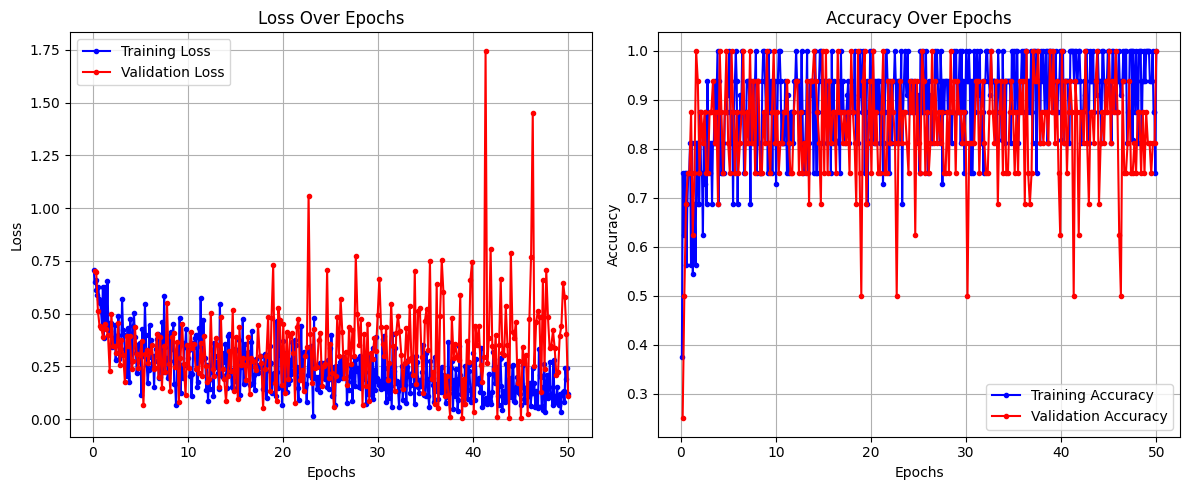

In [38]:
# Plot learning curves
plot_learning_curves(model)

## (j) Eine Funktion für Training und Darstellung

Nun führen wir alles in einer einzigen Funktion zusammen.

In [39]:
def TrainAndPlot(n_hidden=32,max_epochs=50):
    # Model instantiation
    model = ClassifierNet(n_hidden=n_hidden)
    # Trainer setup

    trainer = pl.Trainer(max_epochs=max_epochs, log_every_n_steps=1)
    trainer.fit(model, train_loader, val_loader)
    plot_learning_curves(model)
    

## (j) Ein etwas anderes Netzwerk

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | fc1       | Linear  | 928    | train
1 | relu      | ReLU    | 0      | train
2 | fc2       | Linear  | 1.1 K  | train
3 | output    | Linear  | 33     | train
4 | sigmoid   | Sigmoid | 0      | train
5 | criterion | BCELoss | 0      | train
----------------------------------------------
2.0 K     Trainable params
0         Non-trainable params
2.0 K     Total params
0.008     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


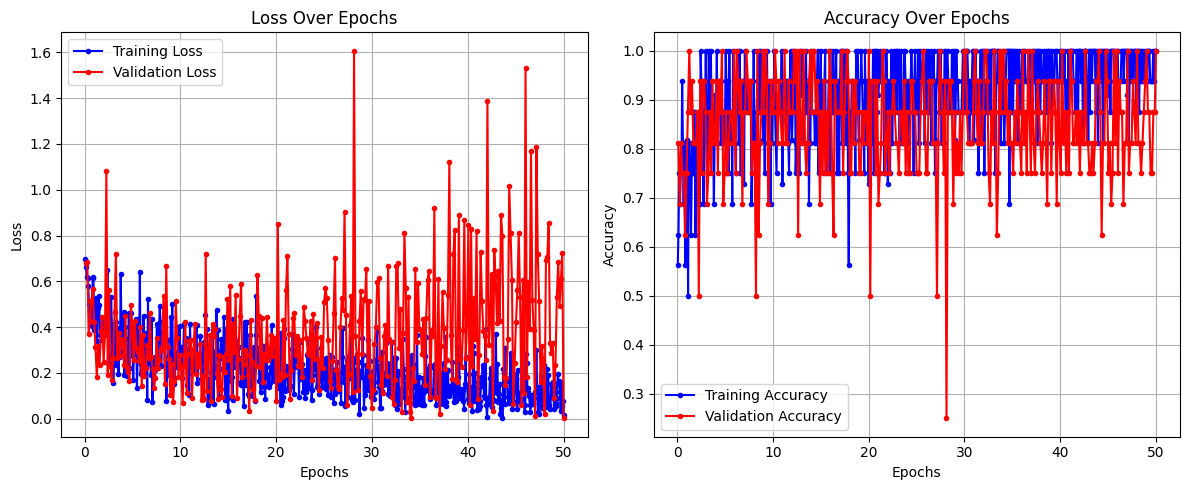

In [40]:
TrainAndPlot(n_hidden=32,max_epochs=50)   

## (f) Variable Anzahl an Hidden Layer

In [41]:
class ClassifierNet(pl.LightningModule):
    def __init__(self, layer_sizes):
        """
        Initialize the classifier network.
        
        Args:
        - layer_sizes (list): A list of integers specifying the number of nodes
                              in each hidden layer. The first element is the input size,
                              and the last element is the output size.
        """
        super(ClassifierNet, self).__init__()

        self.layers = nn.ModuleList()
        for i in range(len(layer_sizes) - 1):
            self.layers.append(nn.Linear(layer_sizes[i], layer_sizes[i + 1]))
            if i < len(layer_sizes) - 2:  # Add dropout only for hidden layers
                self.layers.append(nn.ReLU())
                self.layers.append(nn.Dropout(p=0.5))  # Dropout probability is 0.5

        self.output_activation = nn.Sigmoid()  # Output layer activation for binary classification
        self.criterion = nn.BCELoss()  # Binary Cross-Entropy Loss

        # Initialize metric storage
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return self.output_activation(x)  # Apply sigmoid activation at the output layer

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x).squeeze()
        loss = self.criterion(y_hat, y)
        acc = ((y_hat > 0.5).float() == y).float().mean()
        self.log('train_loss', loss)
        self.log('train_acc', acc, prog_bar=True)
        self.train_losses.append(loss.item())
        self.train_accuracies.append(acc.item())
        return {'loss': loss, 'train_acc': acc}

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x).squeeze()
        loss = self.criterion(y_hat, y)
        acc = ((y_hat > 0.5).float() == y).float().mean()
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)
        self.val_losses.append(loss.item())
        self.val_accuracies.append(acc.item())
        return {'val_loss': loss, 'val_acc': acc}

    def configure_optimizers(self):
        return torch.optim.RMSprop(self.parameters(), lr=0.001)

In [50]:
def TrainPlot(layer_sizes, batch_size, max_epochs=50):
    # Model instantiation
    model = ClassifierNet(layer_sizes)
    # Trainer setup
    summary(model, input_size=(batch_size,28))

    trainer = pl.Trainer(max_epochs=max_epochs, log_every_n_steps=1);
    trainer.fit(model, train_loader, val_loader);
    plot_learning_curves(model)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name              | Type       | Params | Mode 
---------------------------------------------------------
0 | layers            | ModuleList | 2.6 K  | train
1 | output_activation | Sigmoid    | 0      | train
2 | criterion         | BCELoss    | 0      | train
---------------------------------------------------------
2.6 K     Trainable params
0         Non-trainable params
2.6 K     Total params
0.010     Total estimated model params size (MB)
16        Modules in train mode
0         Modules in eval mode


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 32, 16]             464
              ReLU-2               [-1, 32, 16]               0
           Dropout-3               [-1, 32, 16]               0
            Linear-4               [-1, 32, 32]             544
              ReLU-5               [-1, 32, 32]               0
           Dropout-6               [-1, 32, 32]               0
            Linear-7               [-1, 32, 32]           1,056
              ReLU-8               [-1, 32, 32]               0
           Dropout-9               [-1, 32, 32]               0
           Linear-10               [-1, 32, 16]             528
             ReLU-11               [-1, 32, 16]               0
          Dropout-12               [-1, 32, 16]               0
           Linear-13                [-1, 32, 1]              17
          Sigmoid-14                [-1

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


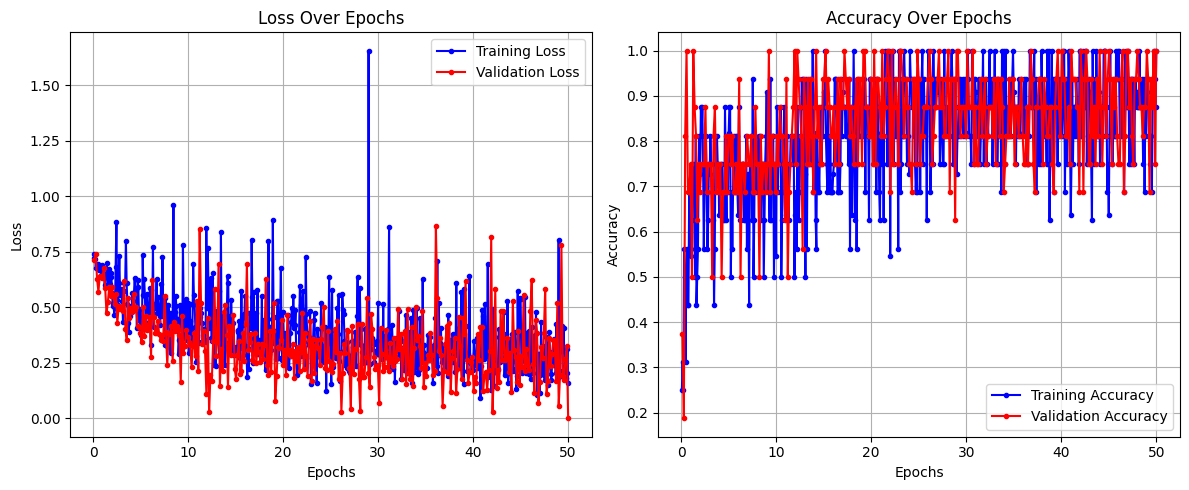

In [51]:
# Example usage
layer_sizes = [28, 16, 32, 32, 16, 1]  # Input size, hidden layers, output size
bstch_size=32
TrainPlot(layer_sizes,bstch_size, max_epochs=50)  